# Week 3 Day 1

Welcome to Google Colab - using free and powerful compute in the cloud.

Google Colab gives you a remote Notebook-style browser window on to a machine, and you run code "locally" on that machine.

## Benefits of Colab

1. Free access to T4 GPUs!
2. Easy ability to share code and collaborate on it
3. Everyone gets to use identical code - no environment differences

## Downsides of Colab

1. As it's free, Google reserves the right to bump you off the box at any point ("reset the runtime"), and this happens most quickly if no code is running. They can also downgrade you from a T4 to a CPU-only box. Sometimes this happens silently. You need to start everything again from the top. Paid plans last longer.
2. You need to pip install packages every single time (but no pip installs today)
3. There's some latency - it's not as interactive as coding on your own box

## Survival Guide

1. Always start by pressing the drop down arrow by Connect on the top right, and "Connect to a hosted runtime: T4"
2. From that dropdown, "View Resources" to check you have a GPU and monitor memory
3. If things go awry, Runtime >> Disconnect and Delete Runtime, Connect again, and then run cells from the top
4. Always run the pip installs! Ignore pip dependency errors.

Runtime >> Restart session: this restarts the Python Kernel, but pip packages remain installed and the disk remains the same.

Runtime >> Diconnect and delete session. This wipes everything.

In [1]:
!pip install -q --upgrade transformers==4.56.2

In [1]:
# Let's check the GPU - it should be a Tesla T4

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)
  if gpu_info.find('Tesla T4') >= 0:
    print("Success - Connected to a T4")
  else:
    print("NOT CONNECTED TO A T4")

Mon Dec  1 04:44:13 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   66C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Connecting Hugging Face

You'll need to log in to the HuggingFace hub if you've not done so before.

1. If you haven't already done so, create a **free** HuggingFace account at https://huggingface.co and navigate to Settings from the user menu on the top right. Then Create a new API token, giving yourself write permissions.  

**IMPORTANT** when you create your HuggingFace API key, please be sure to select WRITE permissions for your key by clicking on the WRITE tab, otherwise you may get problems later. Not "fine-grained" but "write".

2. Back here in colab, press the "key" icon on the side panel to the left, and add a new secret:  
  In the name field put `HF_TOKEN`  
  In the value field put your actual token: `hf_...`  
  Ensure the notebook access switch is turned ON.

3. Execute the cell below to log in. You'll need to do this on each of your colabs. It's a really useful way to manage your secrets without needing to type them into colab.

In [2]:
from huggingface_hub import login
from google.colab import userdata


hf_token = userdata.get('HF_TOKEN')
login(hf_token, add_to_git_credential=False)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


  0%|          | 0/4 [00:00<?, ?it/s]

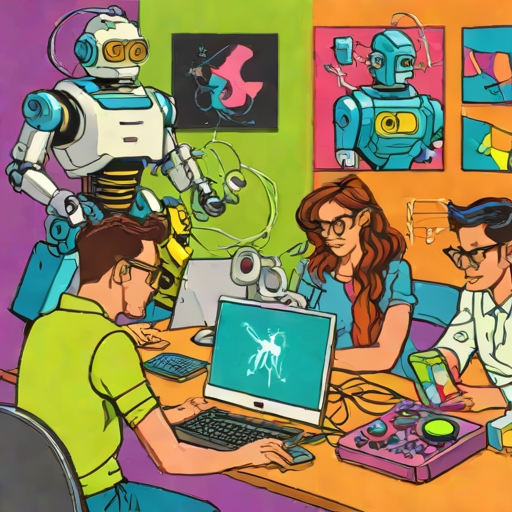

In [4]:
from IPython.display import display
from diffusers import AutoPipelineForText2Image
import torch

pipe = AutoPipelineForText2Image.from_pretrained("stabilityai/sdxl-turbo", torch_dtype=torch.float16, variant="fp16")
pipe.to("cuda")
prompt = "A class of students learning AI engineering in a vibrant pop-art style"
image = pipe(prompt=prompt, num_inference_steps=4, guidance_scale=0.0).images[0]
display(image)


In [5]:
# Restart the kernel

import IPython
IPython.Application.instance().kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

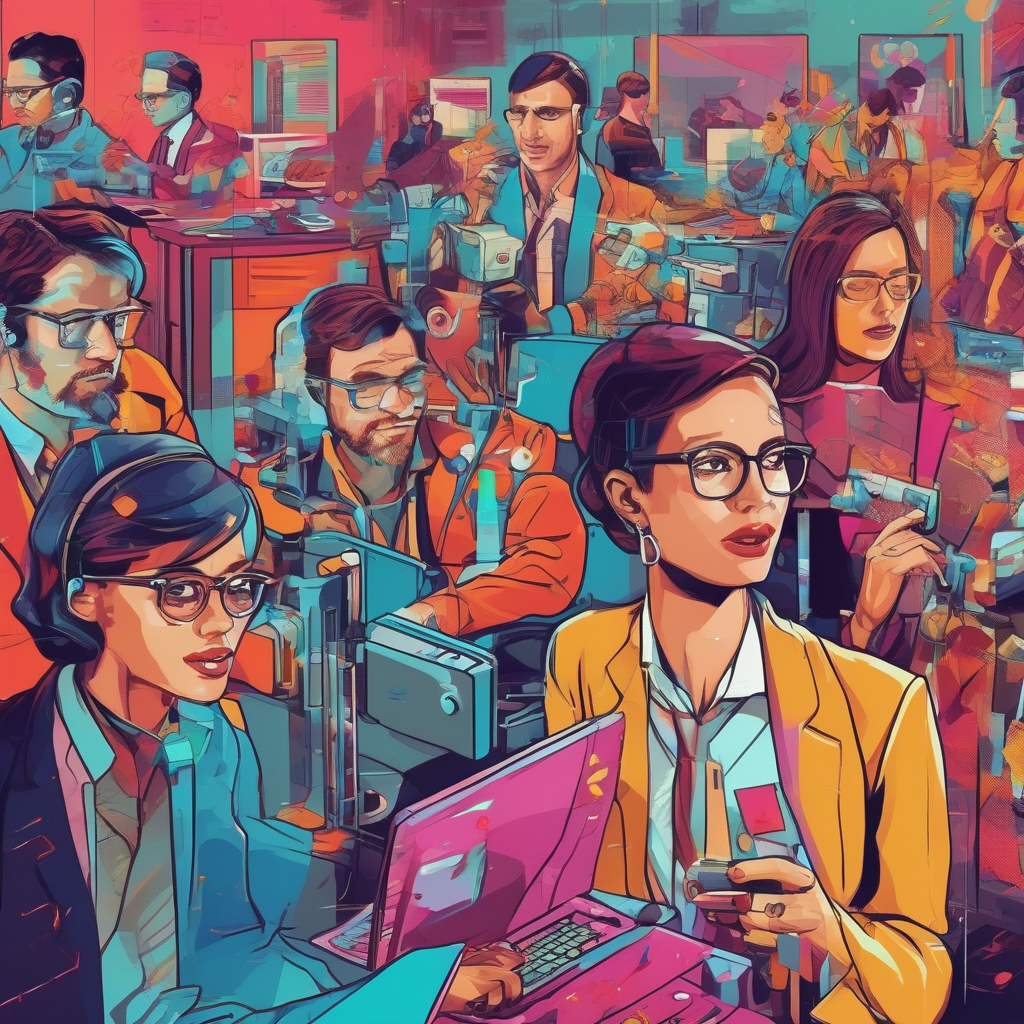

In [6]:
from IPython.display import display
from diffusers import DiffusionPipeline
import torch

pipe = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, use_safetensors=True, variant="fp16")
pipe.to("cuda")

prompt = "A class of data scientists learning AI engineering in a vibrant high-energy pop-art style"

image = pipe(prompt=prompt, num_inference_steps=30).images[0]

display(image)


In [7]:
# Restart the kernel

import IPython
IPython.Application.instance().kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

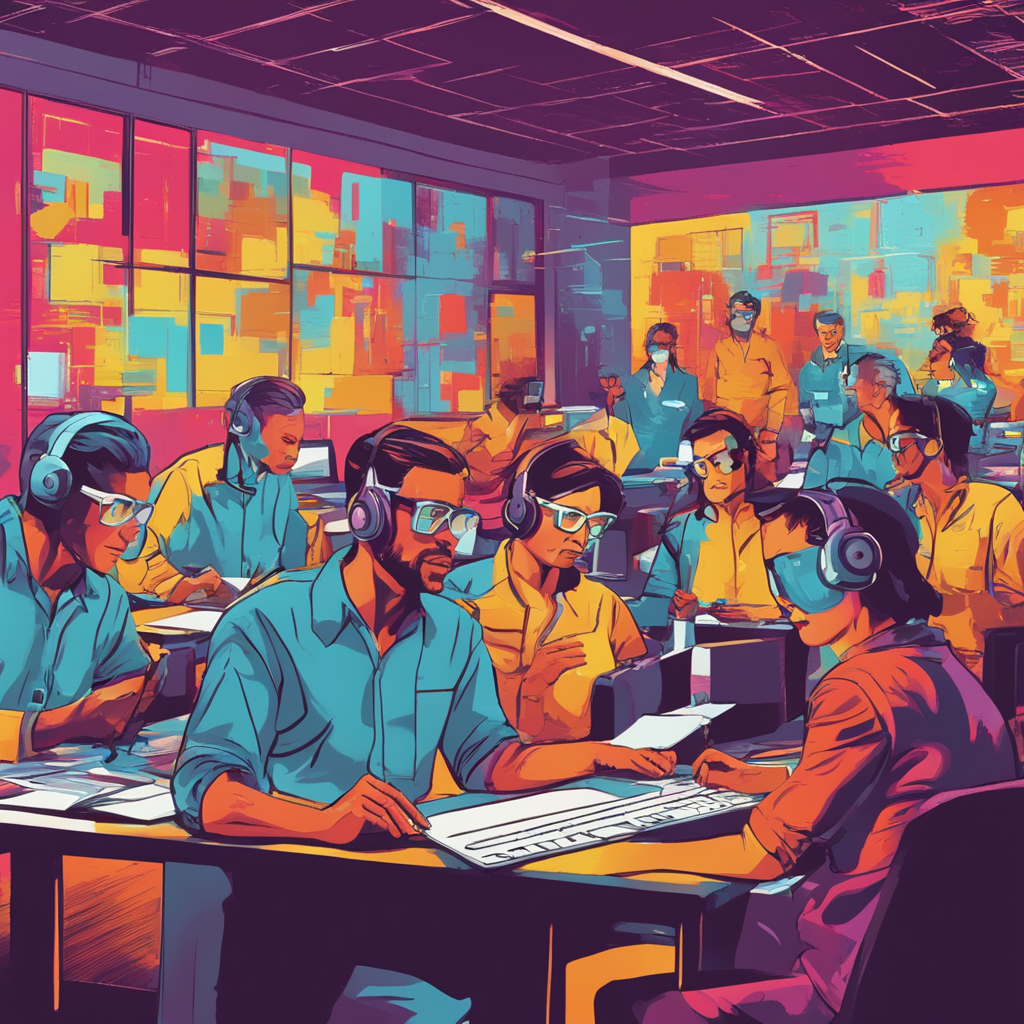

In [3]:
from diffusers import DiffusionPipeline
import torch

base = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, variant="fp16", use_safetensors=True)
base.to("cuda")
refiner = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-xl-refiner-1.0", text_encoder_2=base.text_encoder_2, vae=base.vae, torch_dtype=torch.float16, use_safetensors=True, variant="fp16",)
refiner.to("cuda")

# Define how many steps and what % of steps to be run on each experts (80/20) here
n_steps = 40
high_noise_frac = 0.8

prompt = "A class of data scientists learning AI engineering in a vibrant high-energy pop-art style"

# run both experts
image = base(
    prompt=prompt,
    num_inference_steps=n_steps,
    denoising_end=high_noise_frac,
    output_type="latent",
).images

image = refiner(
    prompt=prompt,
    num_inference_steps=n_steps,
    denoising_start=high_noise_frac,
    image=image,
).images[0]

display(image)

In [4]:
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

In [3]:
!pip install --upgrade datasets==3.6.0

In [4]:
from transformers import pipeline
from datasets import load_dataset
import soundfile as sf
import torch
from IPython.display import Audio

synthesiser = pipeline("text-to-speech", "microsoft/speecht5_tts", device='cuda')
embeddings_dataset = load_dataset("matthijs/cmu-arctic-xvectors", split="validation", trust_remote_code=True)
speaker_embedding = torch.tensor(embeddings_dataset[7306]["xvector"]).unsqueeze(0)
speech = synthesiser("Hi to an artificial intelligence engineer, on the way to mastery!", forward_params={"speaker_embeddings": speaker_embedding})

Audio(speech["audio"], rate=speech["sampling_rate"])

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/585M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/585M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/232 [00:00<?, ?B/s]

spm_char.model:   0%|          | 0.00/238k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/40.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

Device set to use cuda


config.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/50.7M [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/50.6M [00:00<?, ?B/s]

cmu-arctic-xvectors.py: 0.00B [00:00, ?B/s]

spkrec-xvect.zip:   0%|          | 0.00/17.9M [00:00<?, ?B/s]

Generating validation split: 0 examples [00:00, ? examples/s]

In [5]:
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

## This next cells will only work on a powerful GPU box like an A100

This is not available on a free T4 box.

I just want to show off what's possible with a small paid budget..

Rough pricing:

- $9.99 = 100 compute units
- An A100 = 5.37 compute units per hour as of Oct 2025 (for me)

In [3]:
# Let's check the GPU - it should be an A100

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)
  if gpu_info.find('A100') >= 0:
    print("Success - Connected to an NVIDIA A100")
  else:
    print("NOT CONNECTED TO AN A100")

Mon Dec  1 04:49:11 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   59C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import torch
from diffusers import FluxPipeline
from IPython.display import display
from datetime import datetime

start = datetime.now()

pipe = FluxPipeline.from_pretrained("black-forest-labs/FLUX.1-schnell", torch_dtype=torch.bfloat16).to("cuda")
generator = torch.Generator(device="cuda").manual_seed(0)
prompt = "A class of data scientists learning AI engineering in a vibrant high-energy pop-art style"

# Generate the image using the GPU
image = pipe(
    prompt,
    guidance_scale=0.0,
    num_inference_steps=4,
    max_sequence_length=256,
    generator=generator
).images[0]

display(image)

stop = datetime.now()


In [ ]:
# Cost estimate

seconds = (stop-start).total_seconds()
units_per_hour = 5.37
estimated_units = (5.37 / 3600) * seconds
estimated_cost = estimated_units * (9.99/100)
print(f"This took {seconds:.1f} seconds and cost an estimated ${estimated_cost:.3f}")

# But there's a catch - you pay for all the time the kernel is active, not just while it's actually calculating!
# So remember to shut down a Paid kernel..